# Проект: Решение задач HR-аналитика

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. Необходимо будет решить несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

В ходе выполнения проекта будем придерживаться следующему алгоритму:

- Загрузим необходимые данные для решения каждой из задач;
- Проведем предобработку данных: проверка на пропуски, дубликаты и неявные дубликаты, а также устраним все эти недостатки, если они будут выявлены;
- В исследовательском анализе просмотрим как распределены значения каждого столбца, сделаем из них определенные выводы, далее проанализируем корреляцию признаков, по необходимости избивимся от мультиколлинеарности. Для задачи классификации(увоольнения сотрудника) рассмотрим несколько зависимостей, опишем портрет сотредников, которые увольняются и определим какой вклад в увольнение дает оценка удовлетворенности, определяемая моделью из первой задачи.
- Построим общий пайплайн для нахождения лучшей модели с лучшими гиперпараметрами, который будет в себя включать подготовку данных в виде кодирования признаков и заполнения пропусков, если они будут появляться в процессе кодирования.
- Проведем анализ важности признаков для задачи классификации;
- Сделаем общий вывод по проделанной работе.

In [1]:
pip install missingno 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade scikit-learn

     |████████████████████████████████| 13.5 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 99.5 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install phik

     |████████████████████████████████| 686 kB 1.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
! pip install shap==0.44.1

     |████████████████████████████████| 535 kB 1.2 MB/s eta 0:00:01


## Задача : предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
import missingno as msno
import numpy as np
import seaborn as sns
import warnings
import phik
import shap
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

In [6]:
warnings.filterwarnings('ignore')

In [7]:
try:
    data_train = pd.read_csv('train_job_satisfaction_rate.csv')
    data_test = pd.read_csv('test_features.csv')
    data_target = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    data_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    data_test = pd.read_csv('/datasets/test_features.csv')
    data_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [8]:
print(data_train.info())
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [9]:
print(data_test.info())
data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [10]:
print(data_target.info())
data_target.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**Вывод по первому шагу: Загружены необходимые библиотеки для работы, выведена общая информация о датасетах и выведены сами данные датасетов.**

### Предобработка данных

#### Проверка на пропущенный значения

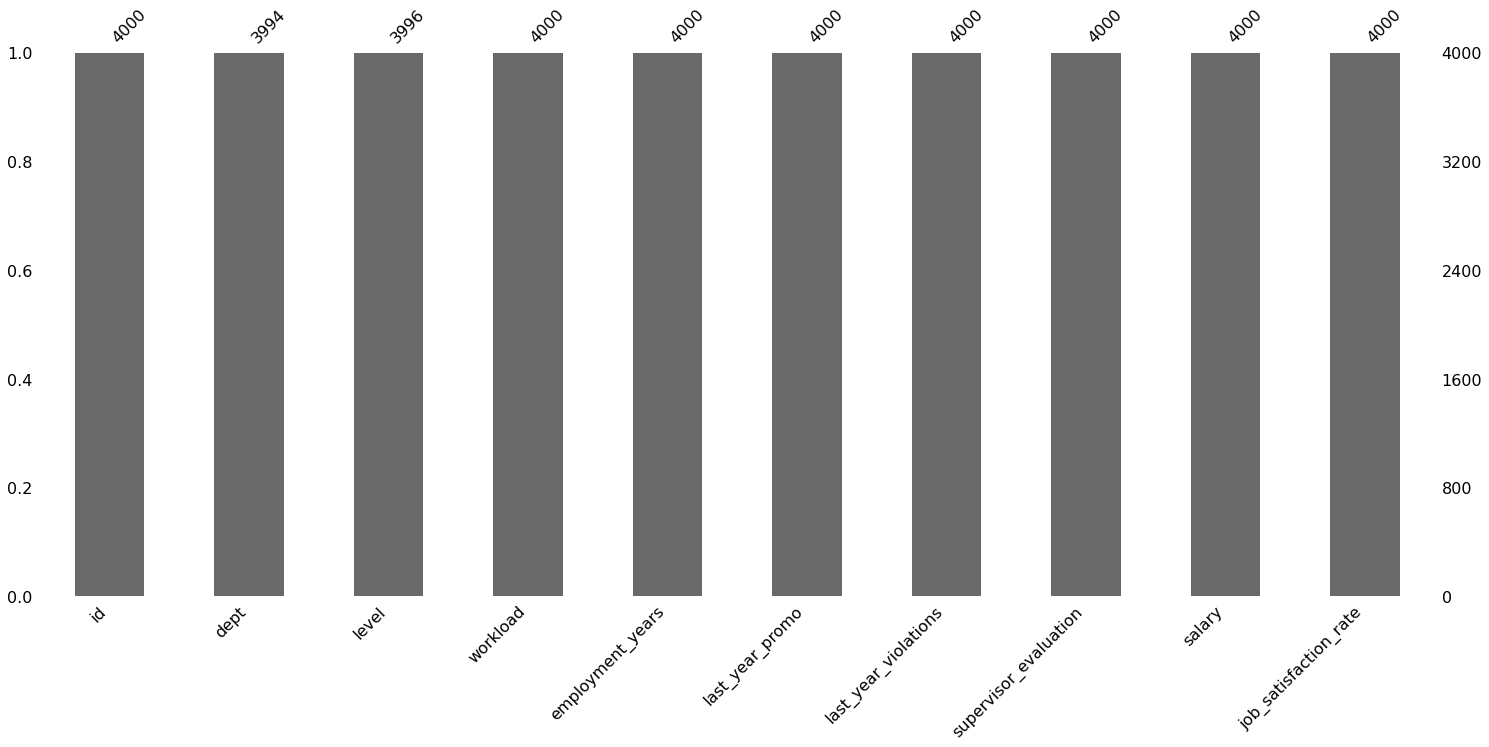

In [11]:
msno.bar(data_train)
plt.show()

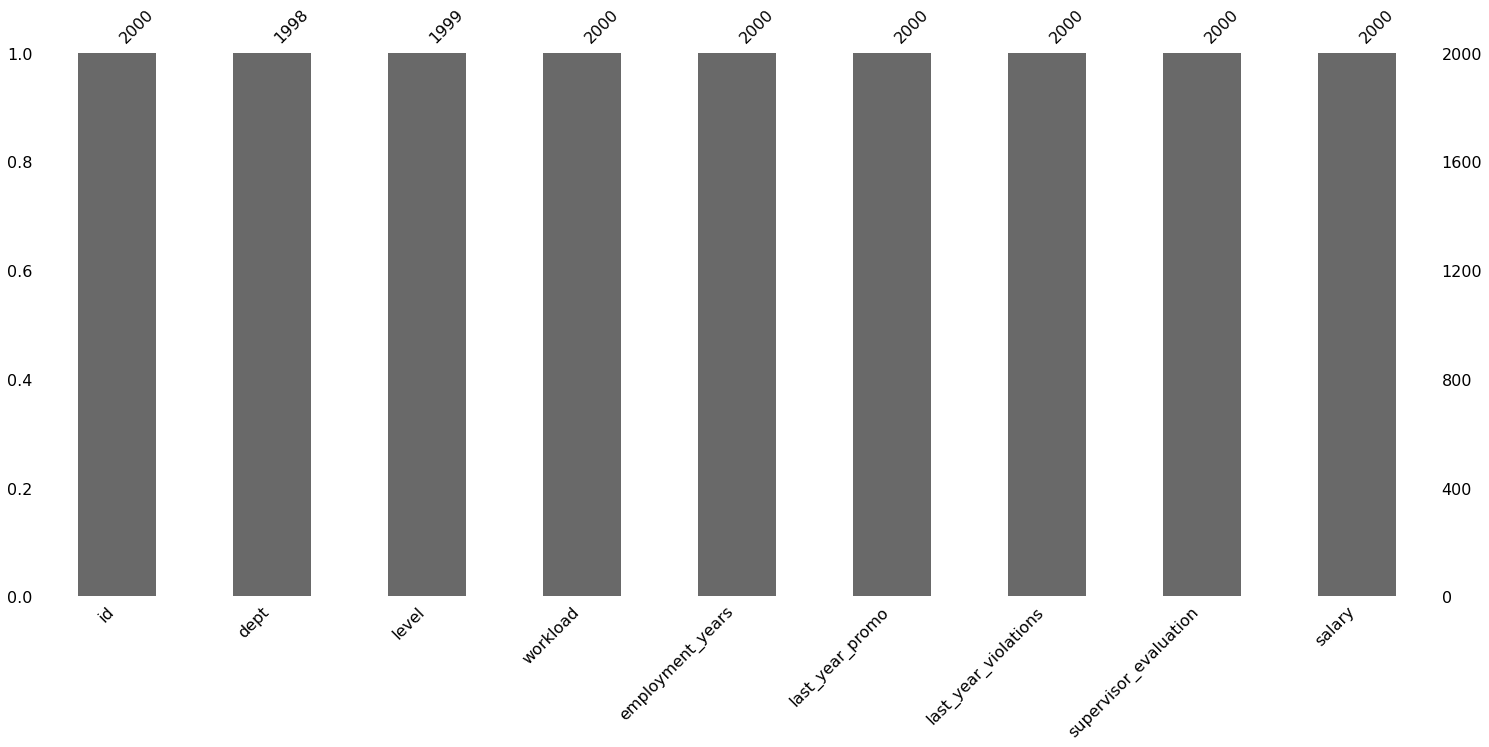

In [12]:
msno.bar(data_test)
plt.show()

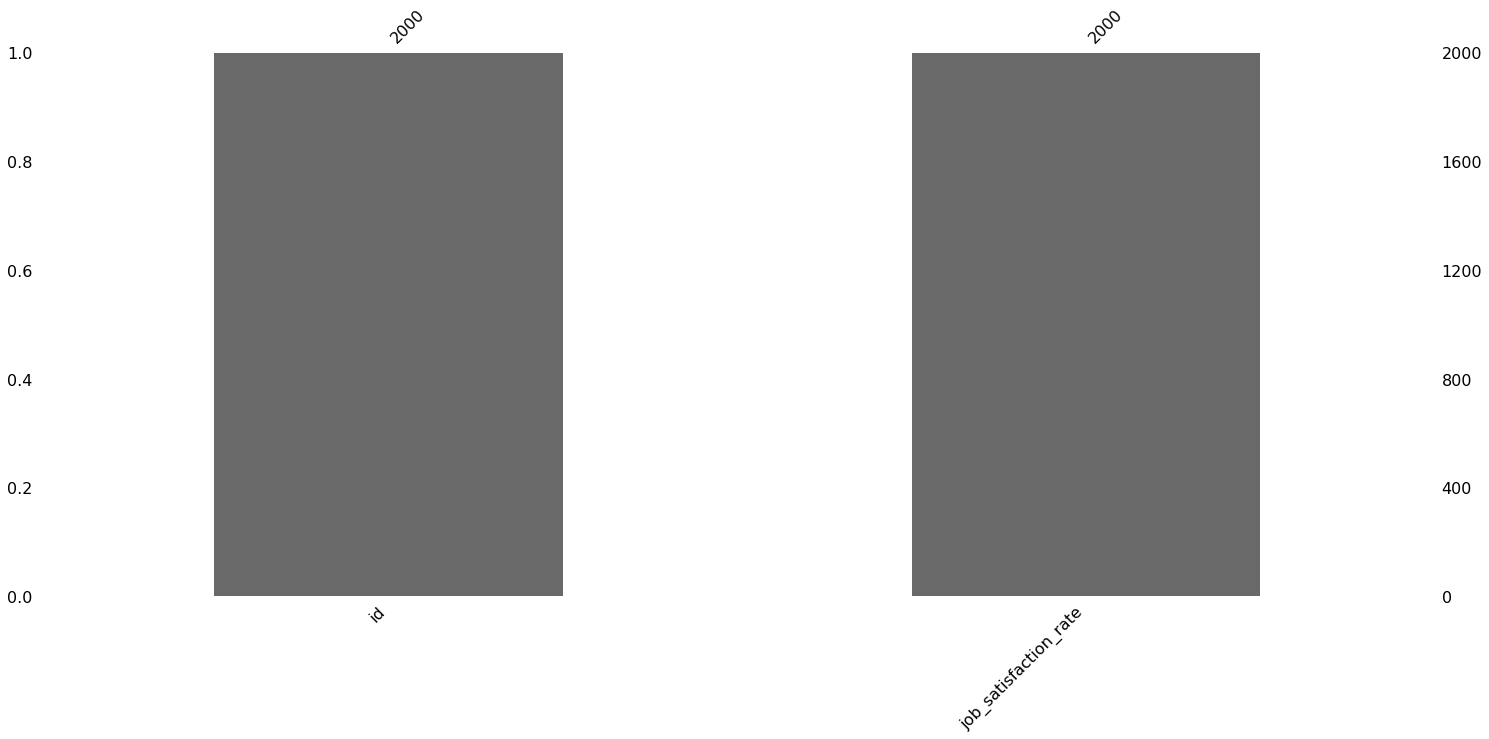

In [13]:
msno.bar(data_target)
plt.show()

In [14]:
data_test.loc[:, ['workload', 'dept']] = data_test.loc[:, ['workload', 'dept']].replace(' ', np.nan)

In [15]:
features_to_impute = ['level', 'dept', 'workload']

In [16]:
imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('impute', imputer, features_to_impute)
    ])

In [18]:
data_train_imputed = preprocessor.fit_transform(data_train)
data_test_imputed = preprocessor.transform(data_test)

In [19]:
data_test_imputed

array([['junior', 'marketing', 'medium'],
       ['junior', 'hr', 'medium'],
       ['middle', 'sales', 'low'],
       ...,
       ['junior', 'technology', 'low'],
       ['middle', 'technology', 'low'],
       ['middle', 'purchasing', 'medium']], dtype=object)

In [20]:
# Преобразование результата в DataFrame
data_test_imputed_df = pd.DataFrame(data_test_imputed, columns=features_to_impute)
data_train_imputed_df = pd.DataFrame(data_train_imputed, columns=features_to_impute)
data_test_imputed_df.head()

,level,dept,workload
0,junior,marketing,medium
1,junior,hr,medium
2,middle,sales,low
3,middle,sales,low
4,middle,hr,medium


In [21]:
data_train['dept'], data_train['level'] = data_train_imputed_df['dept'], data_train_imputed_df['level']
data_test['dept'], data_test['level'], data_test['workload'] = (data_test_imputed_df['dept'], data_test_imputed_df['level'], 
                                         data_test_imputed_df['workload'])

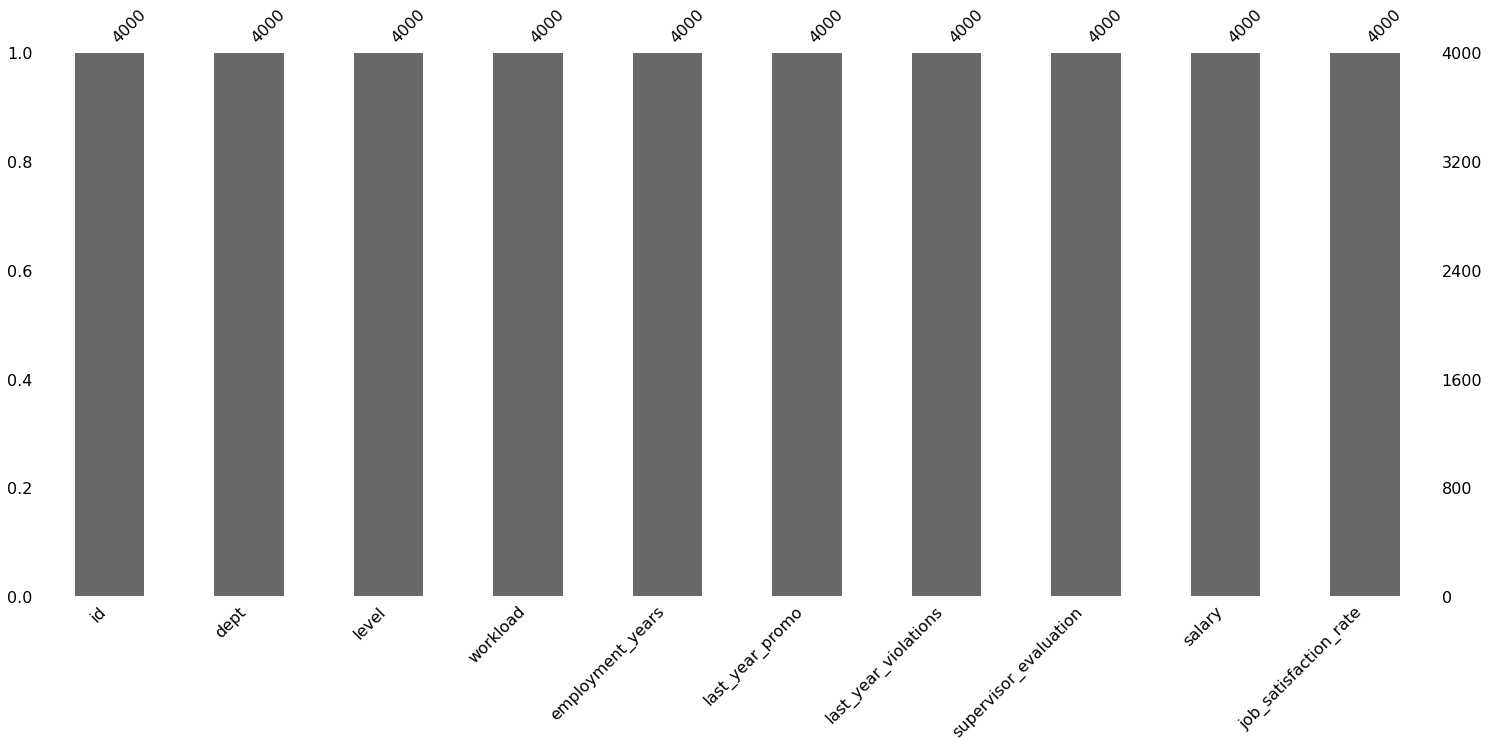

In [22]:
msno.bar(data_train)
plt.show()

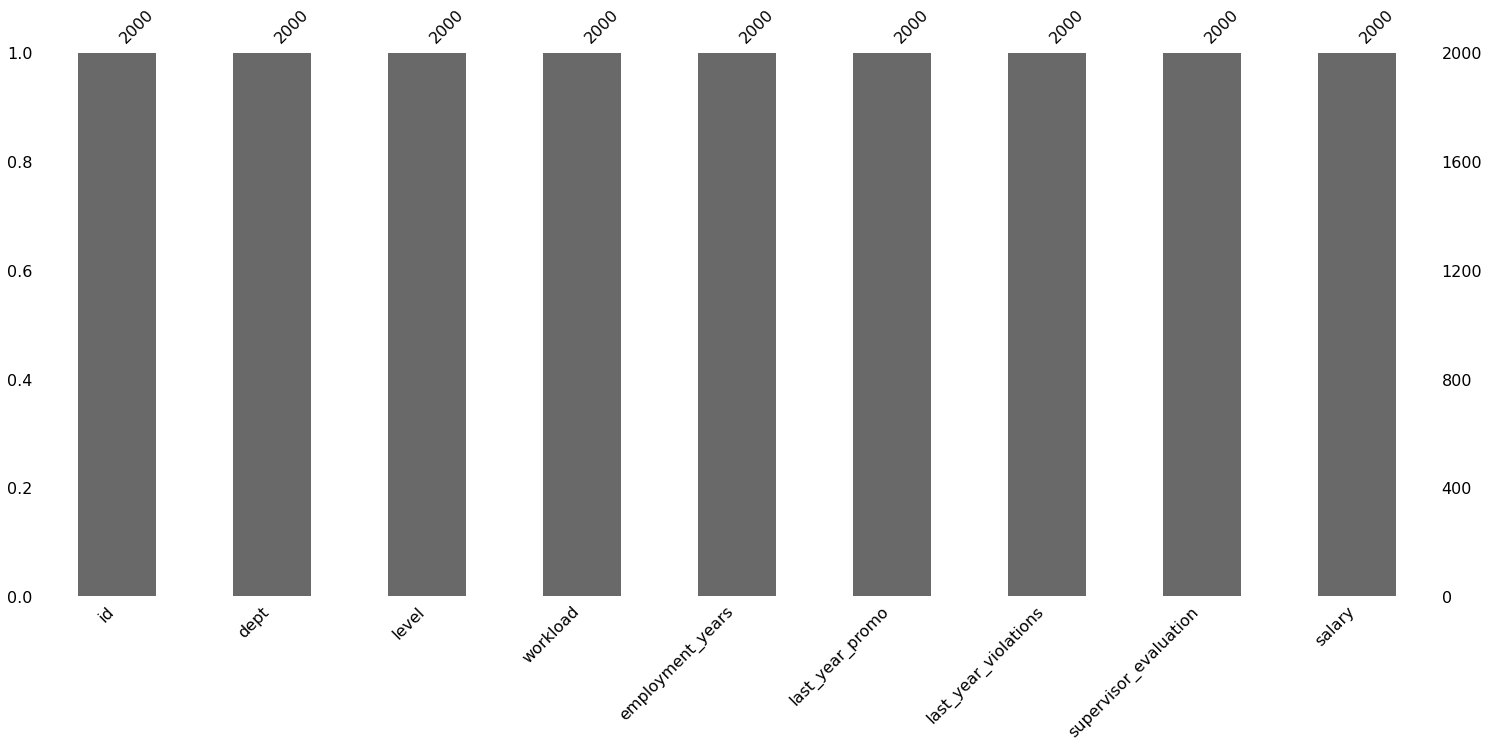

In [23]:
msno.bar(data_test)
plt.show()

#### Проверка на явные дубликаты

In [24]:
data_train.duplicated().sum()

0

In [25]:
data_test.duplicated().sum()

0

#### Проверка на неявные дубликаты

In [26]:
data_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [27]:
print(data_train['dept'].unique())
print(data_train['level'].unique())
print(data_train['last_year_promo'].unique())
print(data_train['last_year_violations'].unique())
print(data_train['workload'].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing']
['junior' 'middle' 'sinior']
['no' 'yes']
['no' 'yes']
['medium' 'high' 'low']


In [28]:
print(data_test['dept'].unique())
print(data_test['level'].unique())
print(data_test['last_year_promo'].unique())
print(data_test['last_year_violations'].unique())
print(data_test['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology']
['junior' 'middle' 'sinior']
['no' 'yes']
['no' 'yes']
['medium' 'low' 'high']


**Вывод по второму шагу: Были обнаружены пропуски в датасетах data_test и data_train в столбцах dept и level, создан и в дальнейшем использован пайплайн для заполнения пропусков. Произведена проверка на явные дубликаты, их обнаружено не было. Также проверили неявные дубликаты, в data_test в столбце dept обнаружена пустая одна пустая строка, заполнена самым популярным значением столбца sales, что собственно и делал пайплайн с другими пропусками.**

### Исследовательский анализ

In [29]:
data_full = data_test.merge(data_target, on='id')
data_full = pd.concat([data_train, data_full], ignore_index=True)
data_full.shape

(6000, 10)

In [30]:
#Функция для построения круговой диаграммы
def pie_plot(data, column):
    plt.pie(data[column].value_counts(), labels=data[column].unique(), autopct='%1.2f%%',
    textprops={'fontsize':10})
    plt.title("Распределение значений столбца " + column)
    plt.show()

In [31]:
#Функция для построения гистограммы диаграммы (непрерывные данные)
def hist_plot_continuous(data, column, string_1):
    plt.hist(data[column])
    plt.xlabel(string_1)
    plt.ylabel('Частота')
    plt.title("Распределение значений столбца " + column)
    plt.show()

In [32]:
#Функция для построения гистограммы диаграммы (дискретные данные)
def hist_plot_discrete(data, column, string_1):
    sns.countplot(data[column])
    plt.xlabel(string_1)
    plt.ylabel('Частота')
    plt.title("Распределение значений столбца " + column)
    for i in range(data[column].value_counts().shape[0]):
        plt.text(i, data[column].value_counts()[i+1], data[column].value_counts()[i+1], ha = 'center')
    plt.show()

#### Построение распределений данных

In [33]:
data_full.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


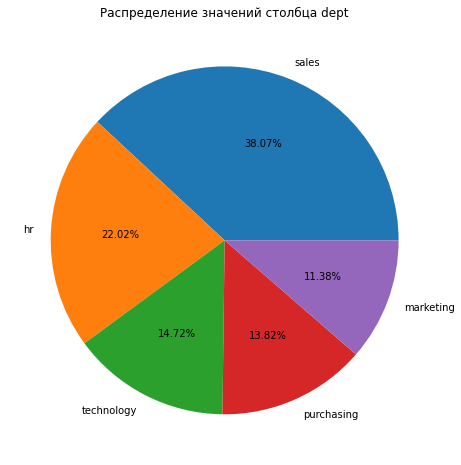

In [34]:
pie_plot(data_full, 'dept')

**В компании большую долю занимают продажники, а меньше всего сотрудников маркетингового отдела**

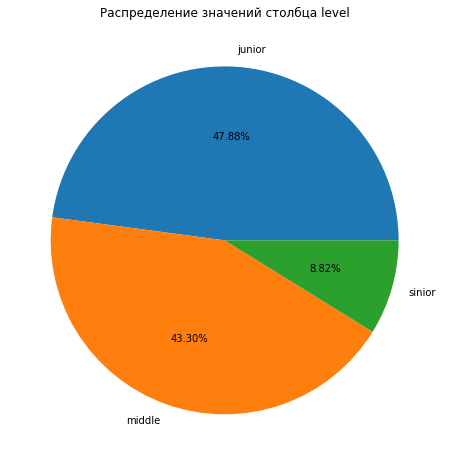

In [35]:
pie_plot(data_full, 'level')

**Опытных сотрудников со статусом sinior меньше 10% в компании, больше всего тех, кто недавно пришел и начинают развиваться, сотрудников со статусом junior.**

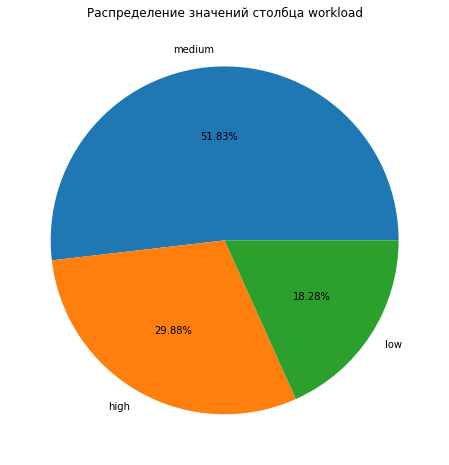

In [36]:
pie_plot(data_full, 'workload')

**В основном у сотрудников средняя рабочая нагрузка, что наверное привлекает новых людей, меньше всего людей с маленькой нагрузкой, меньше пятой части от всех.**

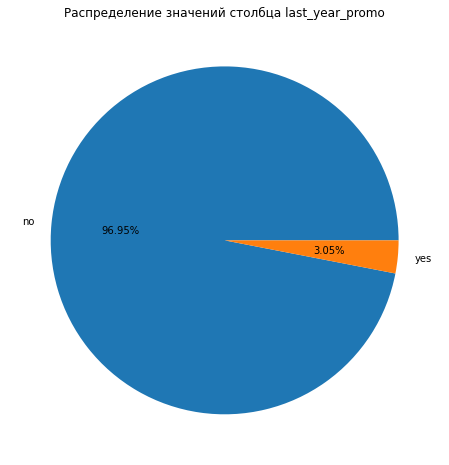

In [37]:
pie_plot(data_full, 'last_year_promo')

**За прошлый год повышение получили только 3% сотрудников.**

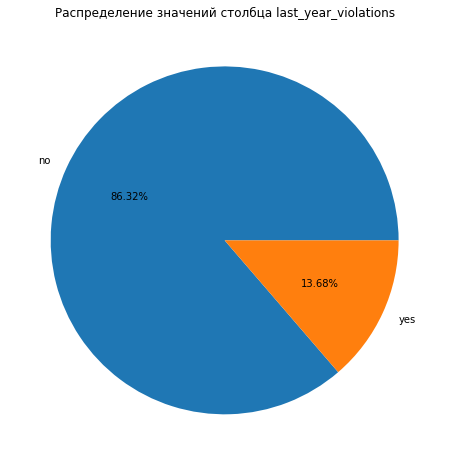

In [38]:
pie_plot(data_full, 'last_year_violations')

**Нарушения договора были обнаружены почти у 14% людей компании, возможно это и повлияло на маленький процент сотрудников с повышением.**

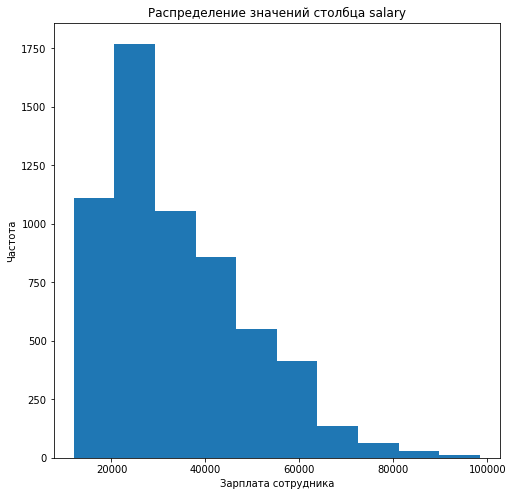

In [39]:
hist_plot_continuous(data_full, 'salary', 'Зарплата сотрудника')

**Большая часть сотрудников имеет зарплату от 20_000 до 40_000.**

In [40]:
data_train['salary'].describe()

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

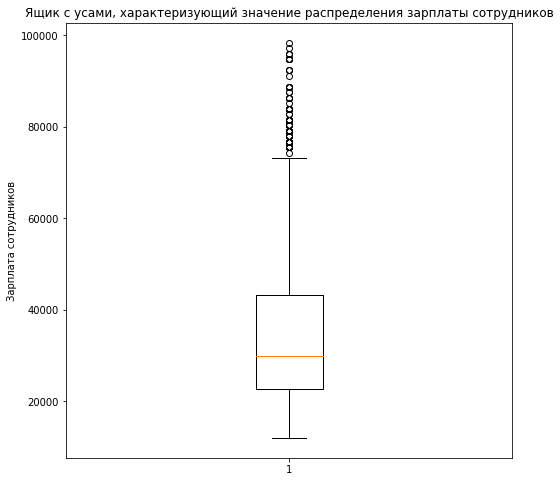

In [41]:
plt.boxplot(data_full['salary'])
plt.ylabel('Зарплата сотрудников')
plt.title('Ящик с усами, характеризующий значение распределения зарплаты сотрудников')
plt.show()

**По построеному ящику с усами для зарплаты наблюдаем наличие выбросов, которые появляются после отметки в 75_000, самая высокая зарплата составляет 98_400, но все таки стоит оставить эти значения, для того, чтобы модель могла работать и с уникальными значениями, которые выше часто встречающихся.**

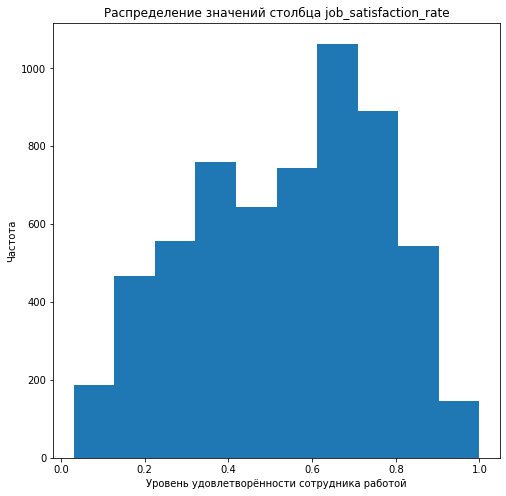

In [42]:
hist_plot_continuous(data_full, 'job_satisfaction_rate', 'Уровень удовлетворённости сотрудника работой')

**Гистограмма по уровню удовлетворенности показывает, что около 700 сотрудников довольны своей работой на 70%, около 550 довольны на 80%, достаточно хороший результат.**

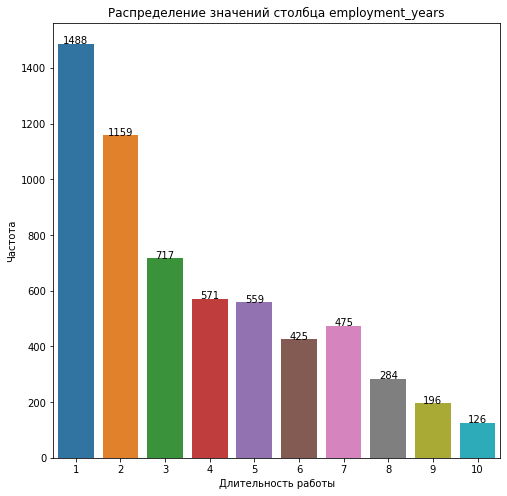

In [43]:
hist_plot_discrete(data_full, 'employment_years', 'Длительность работы')

**Почти 1500 сотрудников имеют стаж 1 год, что собственно и подтверждала круговая диаграмма с уровнем сотрудника, много новичков и мало опытных.**

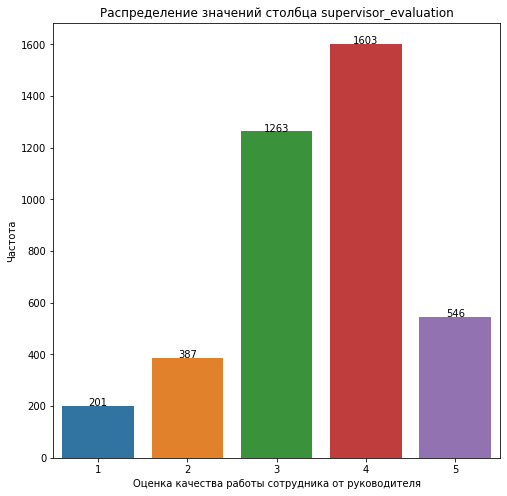

In [44]:
hist_plot_discrete(data_train, 'supervisor_evaluation', 'Оценка качества работы сотрудника от руководителя')

**Достаточно много среднячков с оценкой 3, но все таки если сложить количество сотрудников с оценками 4 и 5, то их намного больше, это означает, что руководитель уделяет время на отбор специолистов или повышение мотивации и квалификации для них.**

#### Корреляционный анализ 

In [45]:
phik_matrix = data_full.drop(columns='id').phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])
phik_matrix

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.026859,0.034162,0.000000,0.000000,0.091179,0.296057,0.050956
level,0.000000,1.000000,0.439275,0.685153,0.106562,0.000000,0.000000,0.726001,0.072844
workload,0.026859,0.439275,1.000000,0.189460,0.049353,0.000000,0.026477,0.788293,0.050544
employment_years,0.034162,0.685153,0.189460,1.000000,0.181423,0.055383,0.000000,0.484380,0.327803
last_year_promo,0.000000,0.106562,0.049353,0.181423,1.000000,0.000000,0.013778,0.207169,0.236337
last_year_violations,0.000000,0.000000,0.000000,0.055383,0.000000,1.000000,0.184669,0.027573,0.559603
supervisor_evaluation,0.091179,0.000000,0.026477,0.000000,0.013778,0.184669,1.000000,0.000000,0.766461
salary,0.296057,0.726001,0.788293,0.484380,0.207169,0.027573,0.000000,1.000000,0.149529
job_satisfaction_rate,0.050956,0.072844,0.050544,0.327803,0.236337,0.559603,0.766461,0.149529,1.000000


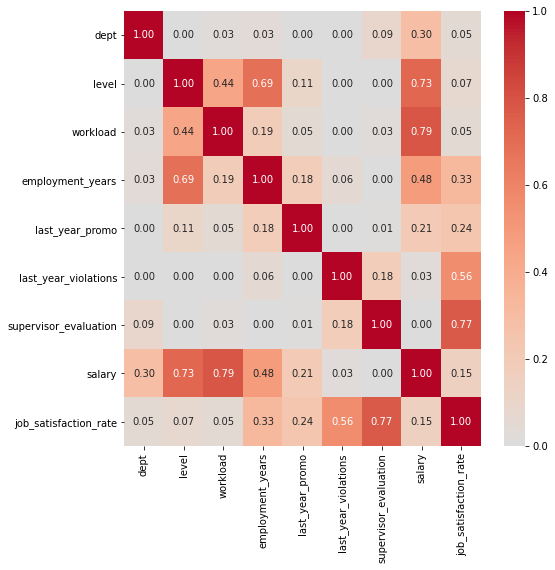

In [46]:
plt.figure(figsize=(8, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.show()

**По корреляционному анализу можно сказать, что мультиколлинеарности не наблюдается между признаками, поэтому все признаки остаются на месте и будут учавствовать в обучении модели.**

**Вывод по третьему шагу: Построены множественные диаграммы, которые показывают распределение значений в каждом столбце датасета. Корреляционный анализ показал, что мультиколлинеарности не наблюдается и все признаки остаются на месте.**

### Подготовка данных и обучение модели

In [47]:
data_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [48]:
#Распределение столбцов по типу кодирования
RANDOM_STATE = 42
num_columns = ['employment_years', 'salary']
ord_columns = ['level', 'workload']
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

In [49]:
# Пайплайн для OrdinalEncoder
ord_pipe = Pipeline([
    ('imputer_before', imputer),
    ('ord', OrdinalEncoder(categories=[['sinior', 'middle', 'junior'],
                                       ['high', 'medium', 'low']],                                      
                                            handle_unknown='use_encoded_value', 
                                            unknown_value=np.nan)),
    ('imputer_after', imputer)
])

In [50]:
# Пайплайн для OneHotEncoder
ohe_pipe = Pipeline([
    ('imputer', imputer),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])


In [51]:
#Соединение всех кодировщиков
data_preprocessor = ColumnTransformer([
                                      ('ohe', ohe_pipe, ohe_columns),
                                      ('ord', ord_pipe, ord_columns),
                                      ('num', StandardScaler(), num_columns),
                                      ],
                                      remainder='passthrough')

In [52]:
#Итоговый пайплайн
final_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [53]:
param_grid = [{'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
               'models__max_depth': range(2, 30),
               'models__max_features': range(2, 30),
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              },
              {'models':[LinearRegression()],
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              },
              {
               'models':[SVR()],
               'models__kernel': ['linear', 'rbf'],
               'models__C': [0.1, 1, 10, 100],
               'models__gamma': ['scale', 'auto'],
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              }
               ]

**Для решения задачи используем Дерево решений, линейную регрессию и модель основанную на методе опорных векторов. Все используется с учетом подбора гиперпараметров.**

In [54]:
# Метрика для оценки модели
def smape(y_true, y_pred):
    smape_value = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    return smape_value

In [55]:
scorer = make_scorer(smape, greater_is_better=False)

In [56]:
data_train = data_train.set_index('id')

In [57]:
randomized_search = RandomizedSearchCV(
    final_pipeline, 
    param_grid, 
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [58]:
X_train = data_train.drop(columns='job_satisfaction_rate')
y_train = data_train['job_satisfaction_rate']

In [59]:
randomized_search.fit(X_train, y_train)
best_model = randomized_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model)
print('Лучшая метрика на кросс-валидации', abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_

In [60]:
data_target = data_target.sort_values(by='id')
data_target.head()

,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


In [61]:
data_test = data_test.sort_values(by='id').set_index('id')
data_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [62]:
test_score = abs(randomized_search.score(data_test, data_target['job_satisfaction_rate']))
test_score

14.347660687172997

**Вывод по первой задаче:  В ходе решения задачи про предсказание уровня удовлетворенности сотрудников компании, был построен пайплайн с тремя моделями Дерево решений, Линейная регрессия и Модель метода опорных векторов. Использовалось два метода кодирования OrdinalEncoder и OneHotEncoder, для кодирования количественных данных использовался StandartScaler. По итогу применения пайплайна к тренировочной выборке получили, что Дерево решений с гиперпараметрами max_depth=16, max_features=22, справилась лучше всего, показав на тренировочной выборке метрику SMAPE=15.17 и на тестовой SMAPE=14.25, при уровне успеха 15 не тестовой выборке. DecisionTreeRegressor хорошо справляется с нелинейными зависимостями и взаимодействиями между признаками, которые могут быть важны для предсказания уровня удовлетворенности сотрудников. Значение max_depth=16 позволяет модели достаточно глубоко разбираться в данных и находить сложные паттерны.**

## Задача: предсказание увольнения сотрудника из компании

### Загрузка данных

In [63]:
try:
    data_train_two = pd.read_csv('train_quit.csv')
    data_test_two = pd.read_csv('test_features.csv')
    data_target_two = pd.read_csv('test_target_quit.csv')
except:
    data_train_two = pd.read_csv('/datasets/train_quit.csv')
    data_test_two = pd.read_csv('/datasets/test_features.csv')
    data_target_two = pd.read_csv('/datasets/test_target_quit.csv')

In [64]:
print(data_train_two.info())
data_train_two.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [65]:
print(data_test_two.info())
data_test_two.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [66]:
print(data_target_two.info())
data_target_two.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Вывод по первому шагу: Загружены новые данные. Выведена общая информация таблиц и их содержимое.**

### Предобработка данных

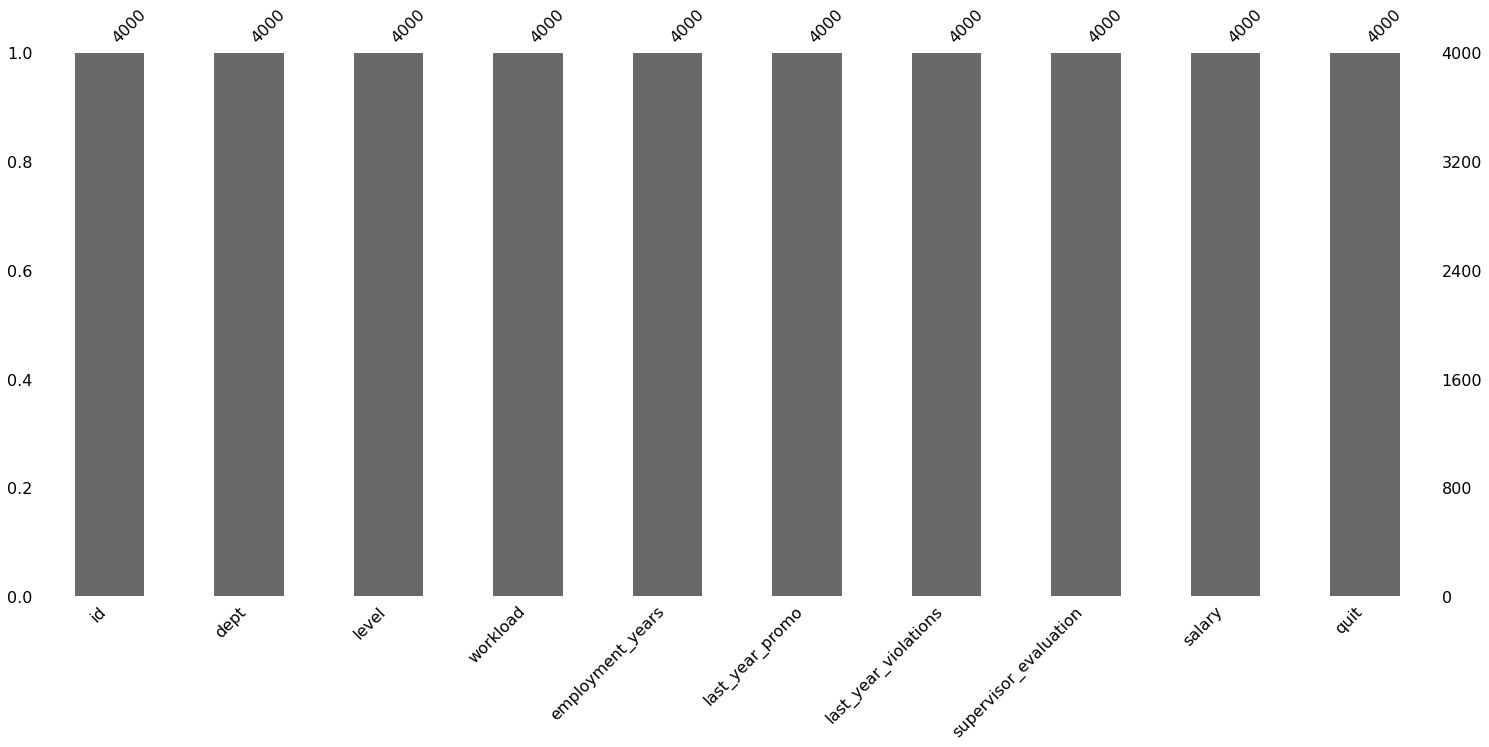

In [67]:
msno.bar(data_train_two)
plt.show()

**В data_train_two пропусков не обнаружено.**

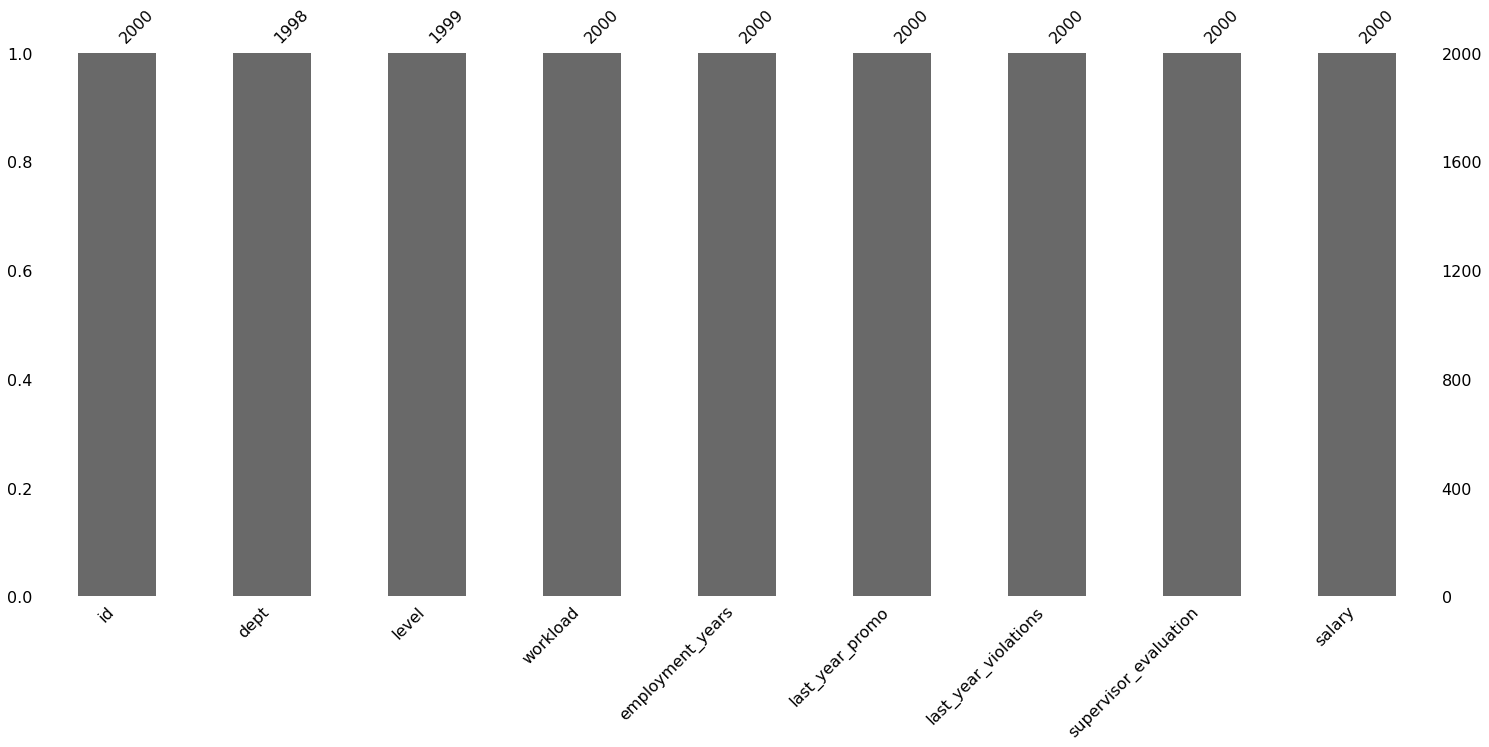

In [68]:
msno.bar(data_test_two)
plt.show()

**В data_test_two есть несколько пропусков в столбце dept и level.**

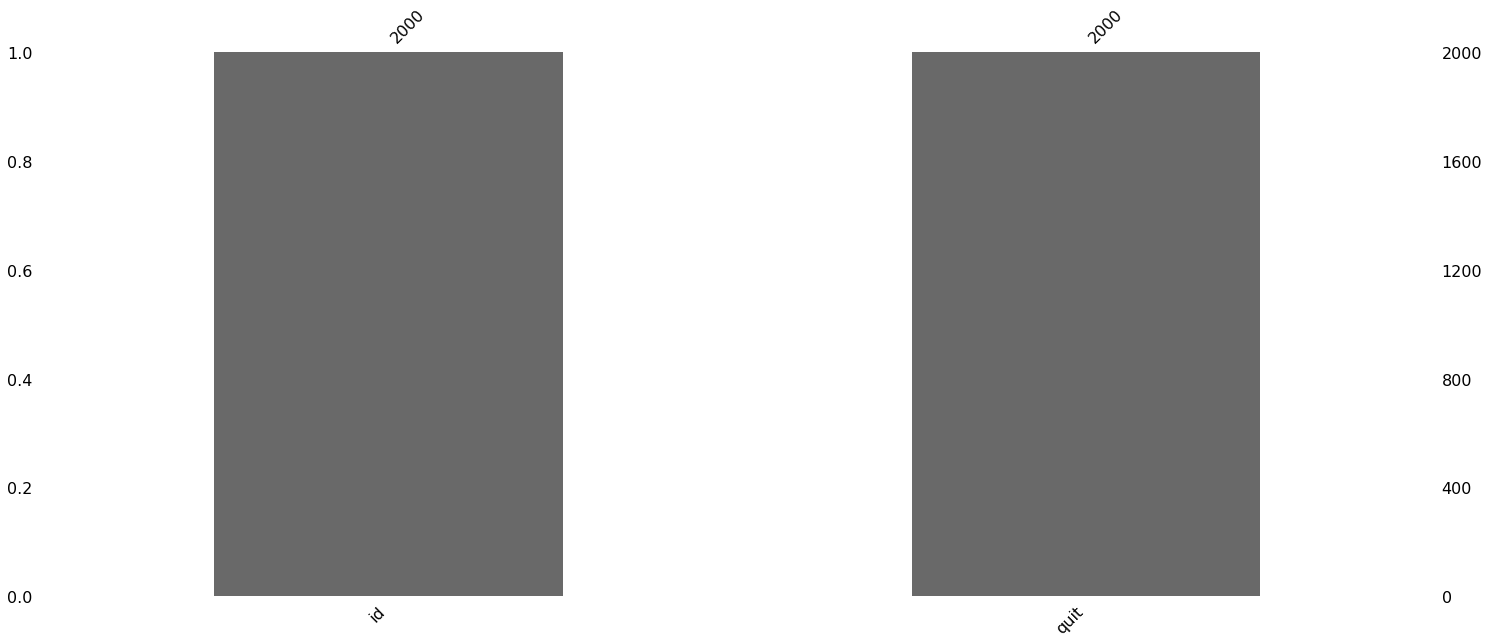

In [69]:
msno.bar(data_target_two)
plt.show()

**В data_target_two пропусков не обнаружено.**

In [70]:
print(data_test_two['dept'].unique())
print(data_test_two['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['medium' 'low' 'high' ' ']


In [71]:
data_test_two.loc[:, ['workload', 'dept']] = data_test_two.loc[:, ['workload', 'dept']].replace(' ', np.nan)

In [72]:
data_test_imputed = preprocessor.transform(data_test_two)
data_test_imputed_df = pd.DataFrame(data_test_imputed, columns=features_to_impute)
data_test_two['dept'] = data_test_imputed_df['dept']
data_test_two['level'] = data_test_imputed_df['level']
data_test_two['workload'] = data_test_imputed_df['workload']
data_test_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


**Избавляемся от пропущенных значений Nan.**

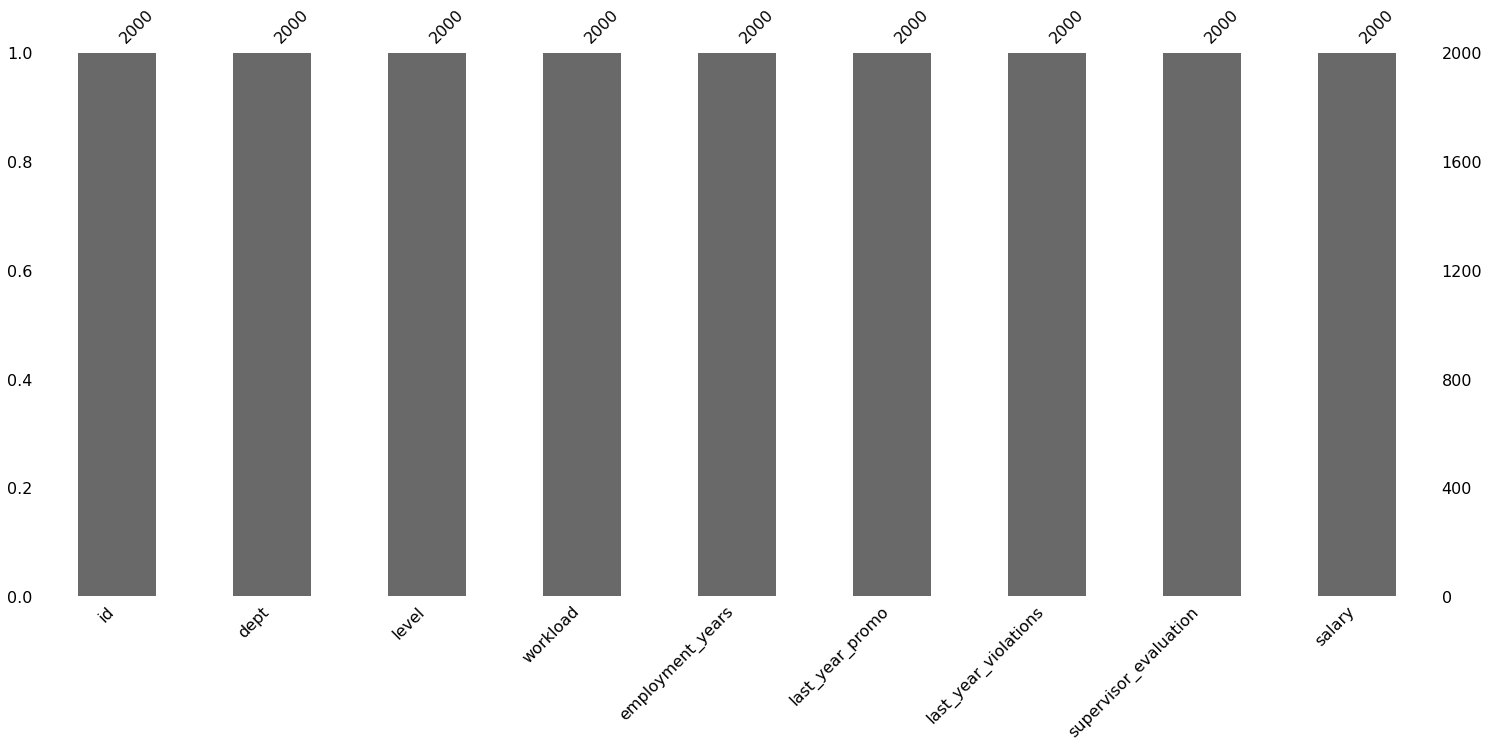

In [73]:
msno.bar(data_test_two)
plt.show()

In [74]:
print(data_test_two['dept'].unique())
print(data_test_two['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology']
['medium' 'low' 'high']


**Вывод по второму шагу: Были обнаружены пропуски в data_test_two, которые были корректно заполнены пайплайном из первой задачи. найдены пустые строки, которые были заполнены nan и обработыны пайплайном.**

### Исследовательский анализ

#### Построение распределений данных

In [75]:
data_full_two = data_test_two.merge(data_target_two, on='id')
data_full_two = pd.concat([data_train_two, data_full_two], ignore_index=True)
data_full_two.shape

(6000, 10)

**Объединяем данные, чтобы было удобнее их исследовать все вместе.**

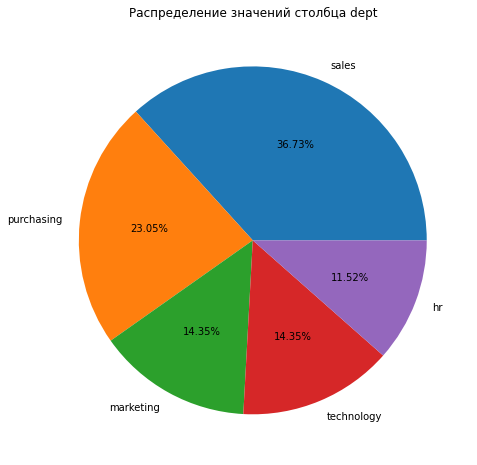

In [76]:
pie_plot(data_full_two, 'dept')

**Сотрудников отдела продаж также много как было представлено в данных первой задачи, но вот наименьшее количество сотрудников уже в отделе HR.**

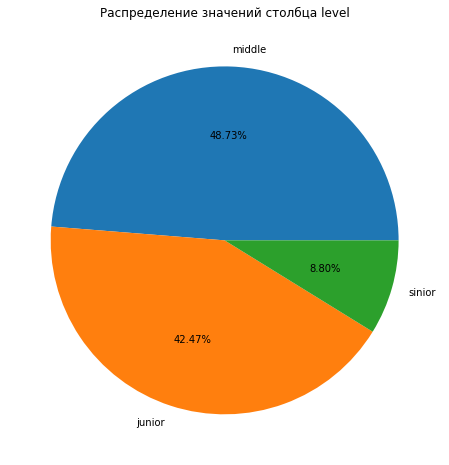

In [77]:
pie_plot(data_full_two, 'level')

**Теперь компания имеет большинство сотрудников среднего статуса middle, что говорит о том, что карьерные рост присутствует. Sinior статусов также мало, меньше 10%.**

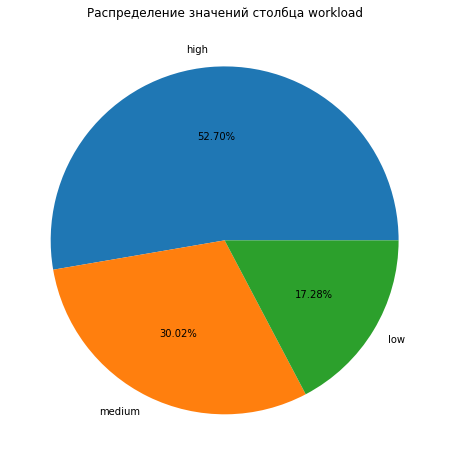

In [78]:
pie_plot(data_full_two, 'workload')

**Из диаграммы видно, что в компании высокий темп работы и нагрузка в основном высокая или средняя.**

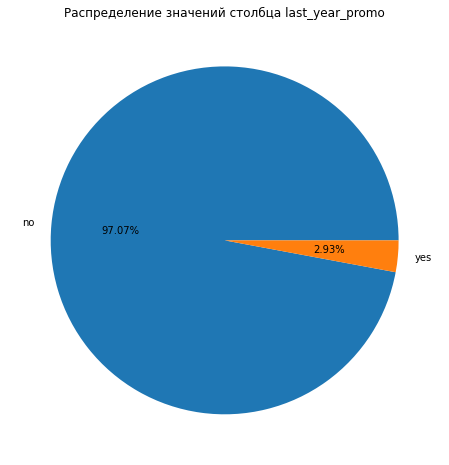

In [79]:
pie_plot(data_full_two, 'last_year_promo')


**Повышений мало, его получисли только около 3% людей.**

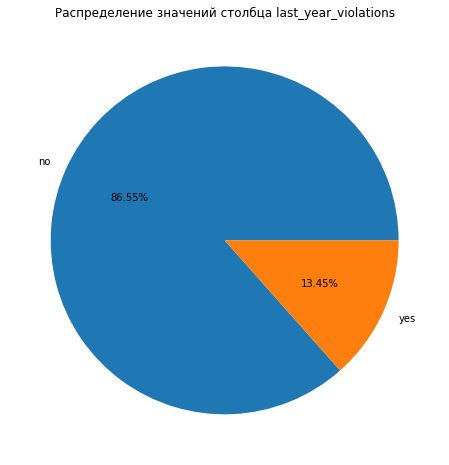

In [80]:
pie_plot(data_full_two, 'last_year_violations')

**Нарушители, к сожалению, присутствуют и их доля составляет 13,5%, не так уж и много, но стоит задуматься о мерах.**

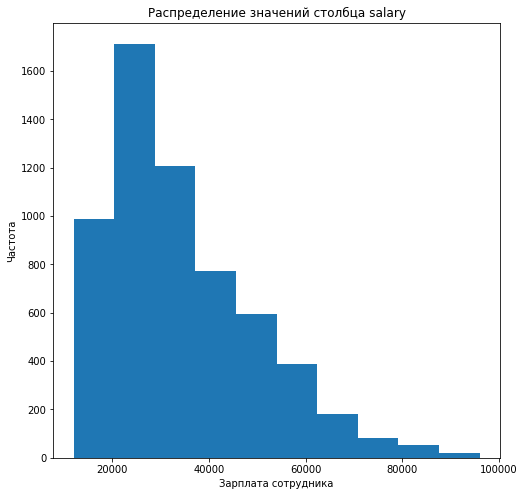

In [81]:
hist_plot_continuous(data_full_two, 'salary', 'Зарплата сотрудника')

**В основном зарплата колеблется от 20_000 до 40_000.**

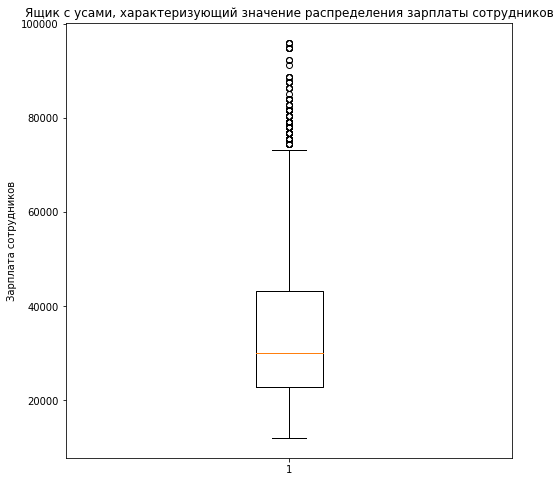

In [82]:
plt.boxplot(data_full_two['salary'])
plt.ylabel('Зарплата сотрудников')
plt.title('Ящик с усами, характеризующий значение распределения зарплаты сотрудников')
plt.show()

In [83]:
data_full_two[data_full_two['salary'] > 75000].shape

(111, 10)

**Наблюдаем наличие выбросов, по сравнению с общим количеством строк их немного, поэтому стоит, чтобы модель умела работать и с выбивающимися значениями.**

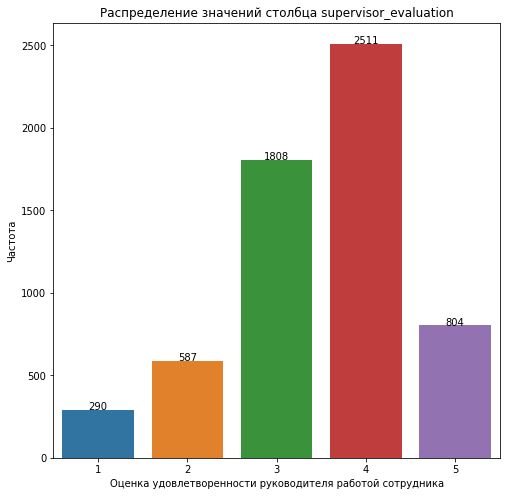

In [84]:
hist_plot_discrete(data_full_two, 'supervisor_evaluation', 'Оценка удовлетворенности руководителя работой сотрудника')

**Большинство сотрудников находятся на хорошем статусе у руководителя, но людей с оценкой 3 тоже прилично, к сожалению.**

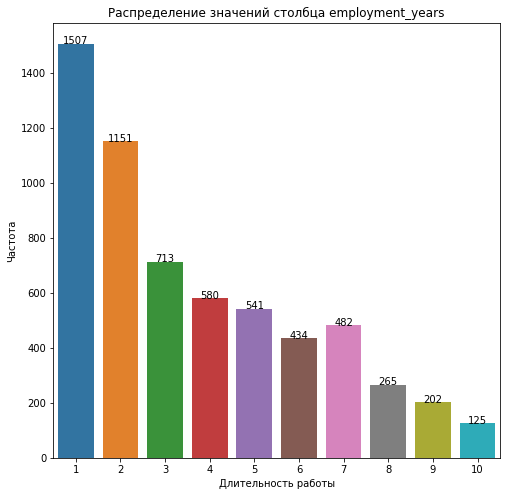

In [85]:
hist_plot_discrete(data_full_two, 'employment_years', 'Длительность работы')

**Много новичков, которые работают меньше четырёх лет. Прослеживается тенденция, чем больше стаж работы, тем меньше людей.**

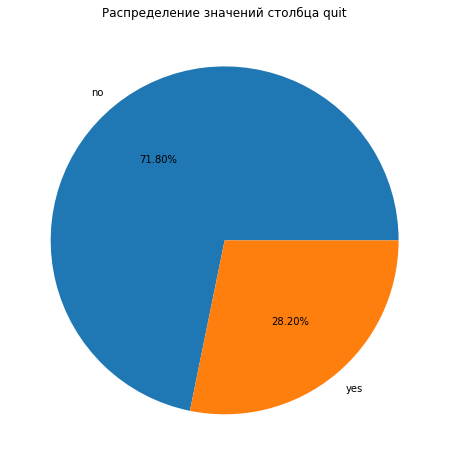

In [86]:
pie_plot(data_full_two, 'quit')

**Почти 30% сотрудников уволились их компании за последний год, достаточно высокий показатель, видимо не все так гладко.**

#### Корреляционный анализ

In [87]:
phik_matrix = data_full_two.drop(columns='id').phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])
phik_matrix

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.000000,0.000000,0.000000,0.000000,0.007646,0.023342,0.050998,0.294827,0.000000
level,0.000000,1.000000,0.477120,0.690890,0.113654,0.000000,0.000000,0.746657,0.306621
workload,0.000000,0.477120,1.000000,0.208336,0.038553,0.009795,0.000000,0.791063,0.122753
employment_years,0.000000,0.690890,0.208336,1.000000,0.162510,0.037950,0.000000,0.488211,0.641861
last_year_promo,0.007646,0.113654,0.038553,0.162510,1.000000,0.000000,0.000000,0.202485,0.153690
last_year_violations,0.023342,0.000000,0.009795,0.037950,0.000000,1.000000,0.182839,0.059704,0.183604
supervisor_evaluation,0.050998,0.000000,0.000000,0.000000,0.000000,0.182839,1.000000,0.087192,0.261976
salary,0.294827,0.746657,0.791063,0.488211,0.202485,0.059704,0.087192,1.000000,0.547422
quit,0.000000,0.306621,0.122753,0.641861,0.153690,0.183604,0.261976,0.547422,1.000000


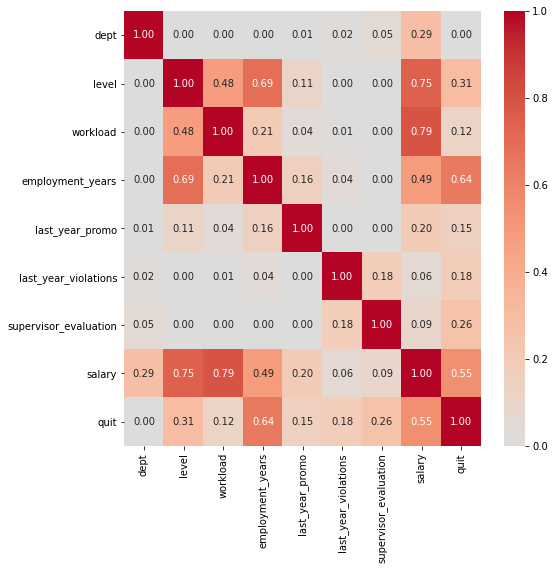

In [88]:
plt.figure(figsize=(8, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.show()

**Мультиколлинеарности не наблюдается, все признаки могут учавствовать в обучении модели.**

#### Портрет уволившегося сотрудника

In [89]:
data_full_two.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [90]:
data_train_quit = data_full_two.query('quit == "yes"')
data_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


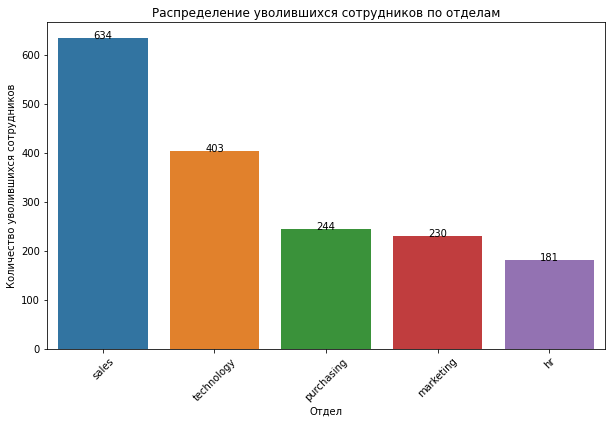

In [91]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data_train_quit, x='dept', order=data_train_quit['dept'].value_counts().index)
plt.title('Распределение уволившихся сотрудников по отделам')
plt.xlabel('Отдел')
plt.ylabel('Количество уволившихся сотрудников')
for i in range(data_train_quit['dept'].value_counts().shape[0]):
        plt.text(i, data_train_quit['dept'].value_counts()[i], data_train_quit['dept'].value_counts()[i], ha = 'center')
plt.xticks(rotation=45)
plt.show()

**Более 600 человек уволились из отдела продаж, но этих сотрудников в компании больше всего, возможно люди шли на временную работу и имели представление о данной работе и им было там легко адаптироваться. Меньше всего увольнений в HR отделе.**

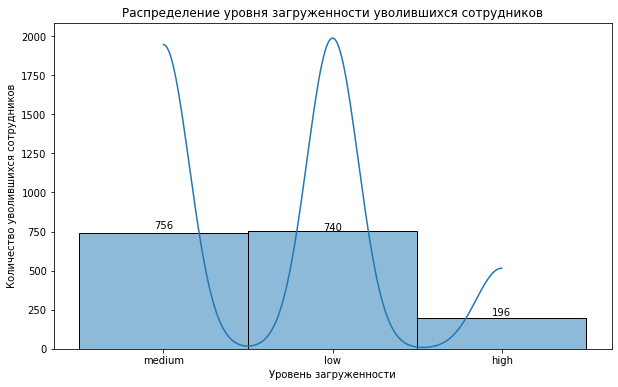

In [92]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_train_quit, x='workload', kde=True)
plt.title('Распределение уровня загруженности уволившихся сотрудников')
plt.xlabel('Уровень загруженности')
plt.ylabel('Количество уволившихся сотрудников')
for i in range(data_train_quit['workload'].value_counts().shape[0]):
        plt.text(i, data_train_quit['workload'].value_counts()[i] + 15, data_train_quit['workload'].value_counts()[i],
                 ha = 'center')
plt.show()

**В основном сотрудники имеют либо низкую, либо среднюю нагрузку своей работы.**

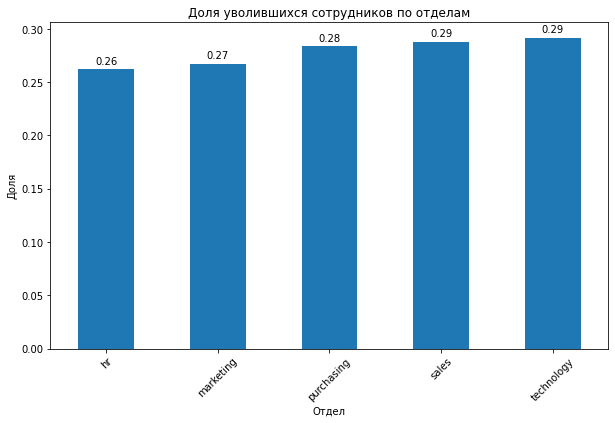

In [93]:
dept_probabilities = data_train_quit['dept'].value_counts() / data_full_two['dept'].value_counts()
dept_probabilities = dept_probabilities.dropna()  
plt.figure(figsize=(10, 6))
dept_probabilities.plot(kind='bar')
plt.title('Доля уволившихся сотрудников по отделам')
plt.xlabel('Отдел')
plt.ylabel('Доля')
for i in range(dept_probabilities.shape[0]):
        plt.text(i, dept_probabilities[i] + 0.005, round(dept_probabilities[i], 2), ha = 'center')
plt.xticks(rotation=45)
plt.show()

**Однако процент уволившихся сотрудников по отношению к общему их количеству самый большой у отдела technology, на втором месте отдел продаж, что было ожидаемо.**

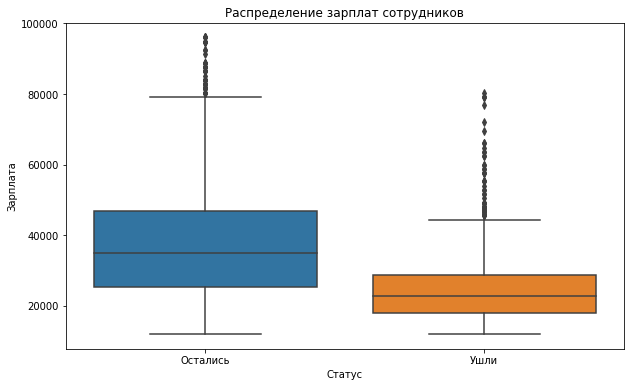

In [94]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_full_two, x='quit', y='salary')
plt.title('Распределение зарплат сотрудников')
plt.xlabel('Статус')
plt.ylabel('Зарплата')
plt.xticks([0, 1], ['Остались', 'Ушли'])
plt.show()

**В основном зарплата тех, кто ушел из компании не привышает и 35_000, что и сподвигает людей уволиться.**

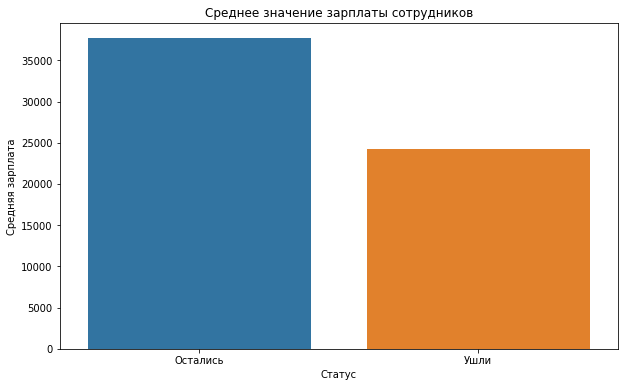

In [95]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data_full_two, x='quit', y='salary', ci=None)
plt.title('Среднее значение зарплаты сотрудников')
plt.xlabel('Статус')
plt.ylabel('Средняя зарплата')
plt.xticks([0, 1], ['Остались', 'Ушли'])
plt.show()

**Значение средней зарплаты и подтверждает показатели ящика с усами.**

#### Проверка утверждения

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

In [96]:
data_test_two.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [97]:
data_target_two = data_target_two.sort_values(by='id')
data_target_two.head()

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


In [98]:
data_test_two = data_test_two.sort_values(by='id')
data_test_two.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [99]:
data_pred = pd.DataFrame({'id': data_target_two['id'],
                          'job_satisfaction_rate': best_model.predict(data_test_two.set_index('id'))})
data_pred.head()

,id,job_satisfaction_rate
1566,100298,0.848000
491,100480,0.850000
802,100503,0.788462
725,100610,0.802857
319,100692,0.693333


In [100]:
data_test_two = data_test_two.merge(data_target_two, on='id').merge(data_pred, on='id')

**В тестовый датасет включаем уровнь удовлетворенности и признак определяющий увольнение.**

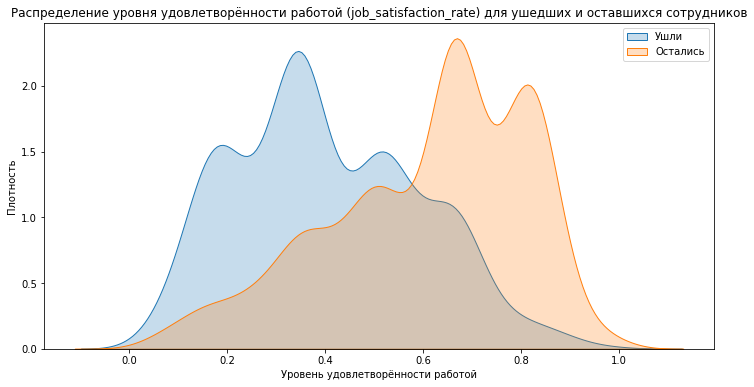

In [101]:
# Визуализация распределения job_satisfaction_rate для ушедших и оставшихся сотрудников
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data_test_two[data_test_two['quit'] == 'yes'], x='job_satisfaction_rate', fill=True, label='Ушли')
sns.kdeplot(data=data_test_two[data_test_two['quit'] == 'no'], x='job_satisfaction_rate', fill=True, label='Остались')
plt.title('Распределение уровня удовлетворённости работой (job_satisfaction_rate) для ушедших и оставшихся сотрудников')
plt.xlabel('Уровень удовлетворённости работой')
plt.ylabel('Плотность')
plt.legend()
plt.show()

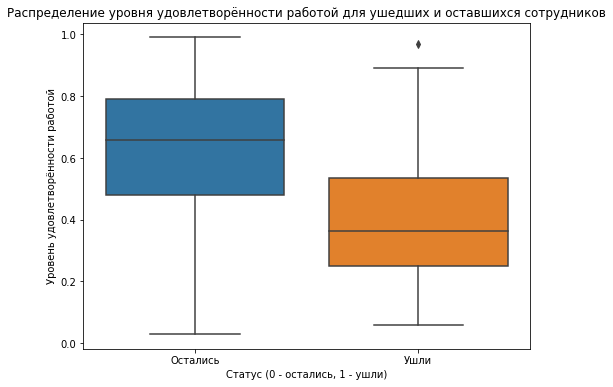

In [102]:
# Визуализация среднего значения job_satisfaction_rate для ушедших и оставшихся сотрудников
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_test_two, x='quit', y='job_satisfaction_rate')
plt.title('Распределение уровня удовлетворённости работой для ушедших и оставшихся сотрудников')
plt.xlabel('Статус (0 - остались, 1 - ушли)')
plt.ylabel('Уровень удовлетворённости работой')
plt.xticks([0, 1], ['Остались', 'Ушли'])
plt.show()

**Видим, что в основные значения удовлетвореннности сотрудников, которые остались выше, чем значения тех, кто ушли, что и следовало ожидать.**

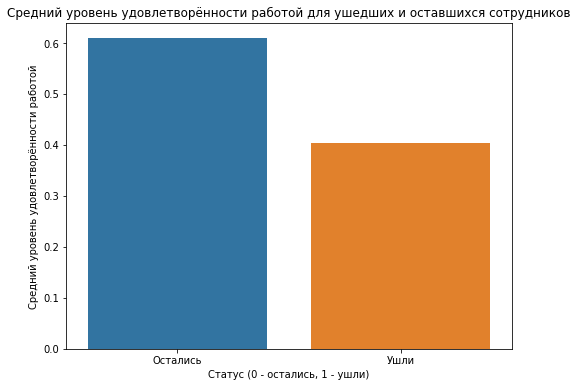

In [103]:
# Визуализация среднего значения job_satisfaction_rate для ушедших и оставшихся сотрудников
plt.figure(figsize=(8, 6))
sns.barplot(data=data_test_two, x='quit', y='job_satisfaction_rate', ci=None)
plt.title('Средний уровень удовлетворённости работой для ушедших и оставшихся сотрудников')
plt.xlabel('Статус (0 - остались, 1 - ушли)')
plt.ylabel('Средний уровень удовлетворённости работой')
plt.xticks([0, 1], ['Остались', 'Ушли'])
plt.show()

**Средний уровень значения удовлетворенности подтверждает выше выведенные диаграммы и графики и в целом получается правдоподобно, что людям, кто остается работать, их деятельность будет нравиться.**

**Вывод по третьему шагу: Построены распределения данных в новых датасетах, к каждому приведен комментарий. Корреляционный анализ выявил, что мультиколлинеарности не наблюдается. Построен портрет уволившихся сотрудников и проанализирована взаимосвязь уровня удовлетворенности сотрудника работой и фактом увольнения.**

### Подготовка данных и обучение модели

In [104]:
data_train_two.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [105]:
data_train_two['job_satisfaction_rate'] = best_model.predict(data_train_two.set_index('id').drop(columns='quit'))

**Добавляем столбец с показателями уровня удовлетворенности сотрудников с помощью модели полученной в предыдущей задачи.**

In [106]:
data_train_two.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.63875
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.82450
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.38000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.38000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.69000


In [107]:
#Разделение признаков на типы
num_columns_two = ['employment_years', 'salary', 'job_satisfaction_rate']
ord_columns_two = ['level', 'workload']
ohe_columns_two = ['last_year_promo', 'last_year_violations', 'dept']

In [108]:
#Пайплайн OrdinalEncoder
ord_pipe_two = Pipeline([
    ('imputer_before', imputer),
    ('ord', OrdinalEncoder(categories=[['sinior', 'middle', 'junior'],
                                           ['high', 'medium', 'low']
                                            ], 
                                            handle_unknown='use_encoded_value', 
                                            unknown_value=np.nan)),
    ('imputer_after', imputer)
])

In [109]:
#Пайплайн OheOneEncoder
ohe_pipe_two = Pipeline([
    ('imputer', imputer),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])


In [110]:
# Соединение всех кодировщиков
data_preprocessor_two = ColumnTransformer([
                                      ('ohe', ohe_pipe, ohe_columns_two),
                                      ('ord', ord_pipe, ord_columns_two),
                                      ('num', StandardScaler(), num_columns_two),
                                      ],
                                      remainder='passthrough')


In [111]:
# Итоговый пайплайн
final_pipeline_two = Pipeline([
    ('preprocessor', data_preprocessor_two),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [112]:
data_target_two.head()

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


In [113]:
le = LabelEncoder()
data_train_two['quit'] = le.fit_transform(data_train_two['quit'])
data_target_two['quit'] = le.transform(data_target_two['quit'])

In [114]:
data_train_two.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,0,0.63875
1,814010,sales,junior,medium,2,no,no,4,27600,0,0.82450
2,155091,purchasing,middle,medium,5,no,no,1,37200,0,0.38000
3,257132,sales,junior,medium,2,no,yes,3,24000,1,0.38000
4,910140,marketing,junior,medium,2,no,no,5,25200,0,0.69000


In [115]:
data_target_two.head()

,id,quit
1566,100298,0
491,100480,0
802,100503,0
725,100610,0
319,100692,0


In [116]:
# Используем несколько моделей для обучения, чтобы найти лучшую
param_grid_two = [{'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
               'models__max_depth': range(2, 10),
               'models__max_features': range(2, 10),
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              },
              {'models':[LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l2')],
               'models__C': range(2, 10),
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              },
              {
               'models':[KNeighborsClassifier()],
               'models__n_neighbors': range(2, 10),
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              }
               ]

In [117]:
# Поиск лучшей модели с лучшими гиперпараметрами
randomized_search_two = RandomizedSearchCV(
    final_pipeline_two, 
    param_grid_two, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [118]:
data_train_two.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,0,0.63875
1,814010,sales,junior,medium,2,no,no,4,27600,0,0.82450
2,155091,purchasing,middle,medium,5,no,no,1,37200,0,0.38000
3,257132,sales,junior,medium,2,no,yes,3,24000,1,0.38000
4,910140,marketing,junior,medium,2,no,no,5,25200,0,0.69000


In [119]:
X_train = data_train_two.set_index('id').drop(columns='quit')
y_train = data_train_two['quit']

In [120]:
randomized_search_two.fit(X_train, y_train)
best_model_two = randomized_search_two.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model_two)
print('Метрика лучшей модели на кросс-валидации:', randomized_search_two.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_vio

In [121]:
# Оценка модели на тестовой выборке
print(f'Метрика ROC-AUC на тестовой  при кросс-валидации:{randomized_search_two.score(data_test_two, data_target_two["quit"])}')

Метрика ROC-AUC на тестовой  при кросс-валидации:0.9221809004523993


In [122]:
dummy = DummyClassifier(random_state=RANDOM_STATE)

In [123]:
dummy.fit(X_train, y_train)
preds = dummy.predict_proba(X_train)[:, 1]

In [124]:
preds_test = dummy.predict_proba(data_test_two)[:, 1]

In [125]:
print(f'Метрика ROC-AUC на тренировочной выборке: {roc_auc_score(y_train, preds)}')
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(data_target_two["quit"], preds_test)}')

Метрика ROC-AUC на тренировочной выборке: 0.5
Метрика ROC-AUC на тестовой выборке: 0.5


**Вывод по четвёртому шагу: На данном этапе был добавлен ещё один признак в тренировочную выборку уровень удовлетворенности работой сотрудника. Построены пайплайны для кодирования признаков. Работа пайплайна по поиску лучшей модели показала, что лучшей моделью снова является модель дерева решений, которая показала на тренировочной выборке метрику ROC_AUC = 0.9225, а на тестовой 0.9203, незначительная разница, данная модель является успешным результатом, так как выполняется условие,
что ROC_AUC > 0.91. Кроме этого, была обучена модель DummyClassifier, для того, чтобы сравнить модель Дерева решений с моделью константных предсказаний, результат Дерева намного превосходит Dummy, поэтому модель получилась качественной.**

### Анализ важности признаков для модели Дерева решений бинарной классификации

In [126]:
data_transformed = best_model_two.named_steps['preprocessor'].transform(data_test_two.set_index('id').drop(columns='quit'))

In [127]:
# Функция для получения имен столбцов после трансформации
def get_feature_names(preprocessor, num_features, ohe_features, ord_features):
    ohe_feature_names = preprocessor.transformers_[0][1]['ohe'].get_feature_names_out(ohe_features)
    ord_feature_names = ord_features  # OrdinalEncoder сохраняет исходные названия
    return np.concatenate([ohe_feature_names, ord_feature_names, num_features])

In [128]:
data_preprocessor_two.fit(X_train)
# Получение названий столбцов после трансформации
transformed_feature_names = get_feature_names(data_preprocessor_two, num_columns_two, ohe_columns_two, ord_columns_two)
transformed_feature_names = np.append(transformed_feature_names, 'supervisor_evaluation')
transformed_feature_names

array(['last_year_promo_yes', 'last_year_violations_yes',
       'dept_marketing', 'dept_purchasing', 'dept_sales',
       'dept_technology', 'level', 'workload', 'employment_years',
       'salary', 'job_satisfaction_rate', 'supervisor_evaluation'],
      dtype=object)

In [129]:
# Создание DataFrame
data_transformed = pd.DataFrame(data_transformed, columns=transformed_feature_names)

In [130]:
# Обучение модели на лучших параметрах
best_model_two.named_steps['models'].fit(data_transformed, data_target_two['quit'])

DecisionTreeClassifier(max_depth=6, max_features=6, random_state=42)

In [131]:
# Вычисление значений SHAP
explainer = shap.TreeExplainer(best_model_two.named_steps['models'])
shap_values = explainer.shap_values(data_transformed)

In [132]:
def heading():
    plt.gca().set_xlabel('SHAP Value', fontsize=12)
    plt.gca().set_ylabel('Признаки', fontsize=12)
    plt.title('SHAP  график для классификатора дерева решений', fontsize=12)
    plt.show()

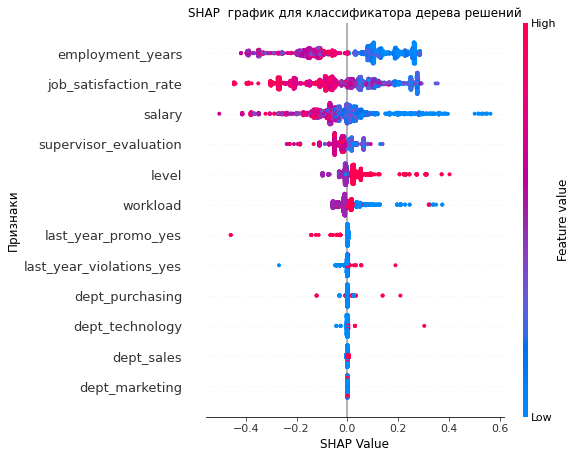

In [133]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[1], data_transformed, plot_type="dot", 
                             feature_names=transformed_feature_names, show=False)
heading()

**Просмотрев диаграмму beeswarm первое что можно сказать и это бросается в глаза, что не все признаки важны для модели, факт повышения сотрудника, факт о нарушении договора, информация о должности сотрудников не дают никакой информации модели, она на них не ориентируется, поэтому можносписок признаков сократить, что ускорить работу модели. Далее, на первом месте находиться признак определяющий стаж работы, чем больше стаж, тем меньше вероятность, что сотрудник уйдет из компании, на втором месте на факт увольнения или его отсутствие влияет оценка руководителя, чем она больше, тем меньше вероятность ухода, что является логичный. Также можно выделить уровень удовлетворенности, которую дает сам сотрудник, так как кучность значений shap, означает, что данный признак добавляет модели уверенности при принятии своего решения.**

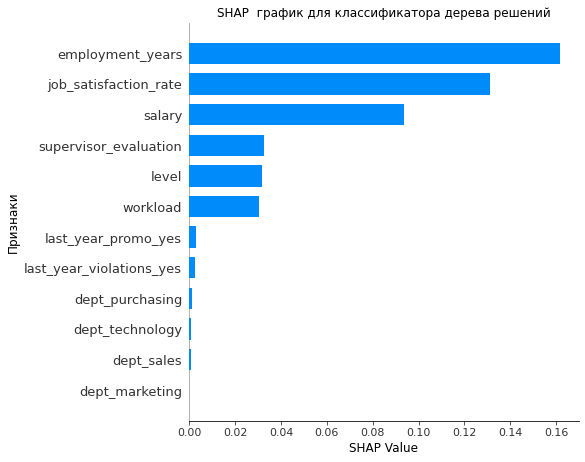

In [134]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[1], data_transformed, plot_type="bar", feature_names=transformed_feature_names, show=False)
heading()

**Горизонтальная bar диаграммы, в точности подтверждает показания beeswarm.**

In [135]:
data_waterfall = pd.DataFrame({'id': data_target_two['id'],
                                 'pred': best_model_two.predict(data_test_two),
                                 'true': data_target_two['quit']})

In [136]:
# Выделяем неверно определенные классы моделью
print(data_waterfall.query('pred == 1 & true == 0').head())
data_waterfall.query('pred == 0 & true == 1').head()

          id  pred  true
700   125082     1     0
1489  125303     1     0
1861  161234     1     0
530   220514     1     0
679   224217     1     0


,id,pred,true
1645,109661,0,1
1250,109800,0,1
1104,116186,0,1
1341,130715,0,1
1947,135876,0,1


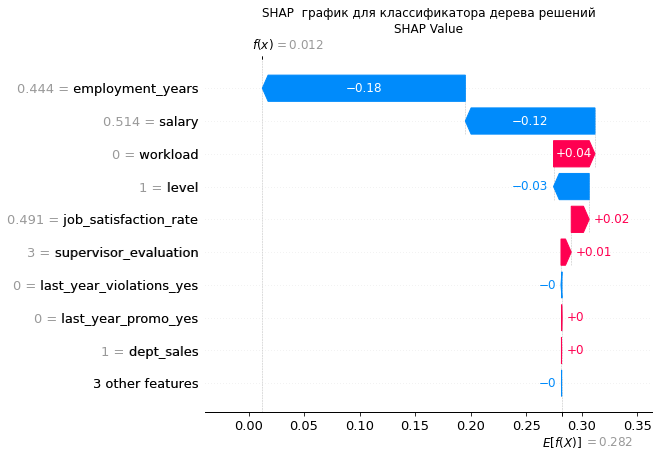

In [137]:
shap.waterfall_plot(shap.Explanation(values=shap_values[1][1250], 
                                     base_values=explainer.expected_value[1], 
                                     data=data_transformed.iloc[1250], 
                                     feature_names=transformed_feature_names), show=False)
heading()

**Рассмотрим объект с номером 1250, по факту он ушел из компании, а модель определила, что он не уволится, на это больше всего повлияли признак уровня должности и рабочий стаж. То есть как эти признаки не помогали бы модели определять верно классы, в такой же степень они могут вводить её в заблуждение.**

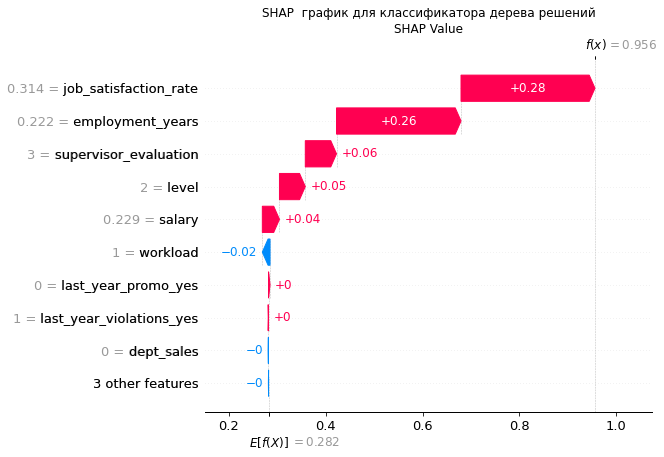

In [138]:
shap.waterfall_plot(shap.Explanation(values=shap_values[1][1055], 
                                     base_values=explainer.expected_value[1], 
                                     data=data_transformed.iloc[1055], 
                                     feature_names=transformed_feature_names), show=False)
heading()

**Рассмотрим объект 1055, где модель определила, что сотрудник уволится, а по факту он остался. Почти все признаки склоняли этот объект к классу увольнения, больше всего склонял признак оценка руководителя и то же самый стаж. Только зарплата и уровень загруженности давали возможность к определению верного класса.**

## Итоговый вывод

В ходе решения задач HR-аналитика, а именно задача регресси по определению уровня удовлетворённости сотрудника компании и вторая про определение уволится ли сотрудник или нет, было проведено следующее исследование:

Общие шаги:

1) Загружены необходимые библиотеки для работы, таблицы, которые были сразу разбиты на тренировочную и тестовую выборки. Просмотрена общая информация и сами данные.

2) Предобработка включала в себя:

- проверку данных на пропуски и соответсвующее устранение их с помощью пайплайна и инструмента SimpleImputer;
    
- проверка на наличие явных дубликатов, их не было обнаружено;
    
- проверка на наличие неявных дубликатов, их обнаружено также не было, но найдены строки с пустыми значеними в некоторых столбцах, которые в дальнейшем были устранены путем заполнения SimpleImputer.

3) Исследовательский анализ: 
- Были построены распределения значений столбцов, соответсвенно для категориальных данных это круговые диаграммы, для дискретных и непрерывных данных столбчатые диаграммы, но разных типов;
- корреляционный анализ показал отсутствие мультиколлинеарности, поэтому все признаки остались на своих местах и учавствовали в построении модели;
- только для второй задач - задачи классификации построен портрет уволившихся сотрудников, были сделаны следующие выводы: 
    - более 600 человек уволились из отдела продаж, но этих сотрудников в компании больше всего, возможно люди шли на временную работу и имели представление о данной работе и им было там легко адаптироваться. Меньше всего увольнений в HR отделе.
    - большая нагрузка не пугает людей, в основном увольняются с средней нагрузкой, либо низкой. Возможно отсюда прослеживается отсутствие карьерного роста, если должность требует малой нагрузки, это может отталкивать людей.
- также для задачи классификации, проверили утверждение "уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник", получили, что уровень удовлетворенности у сотрудников, которые остались выше, чем у тех, кто уволился, этого и следовало ожидать.

Индивидульно под каждую задачу:

1) Задача про уровень удовлетворённости сотрудника включила в себя построение пайплайна для нахождения лучшей модели. Также были добавлены пункты про кодирование признаков, предварительно признаки были разбиты на группы. Рассматривались 3 модели, а именно DecisionTreeRegressor, LinearRegression, SVR. Пайплайн выделил модель DecisionTreeRegressor(max_depth=16, max_features=22, random_state=42), основываясь на метрике SMAPE, для которой былы написана функция и сформирована сама метрика.  На тренировочной выборке получили метрику SMAPE=15.17 и на тестовой SMAPE=14.25, при уровне успеха 15 не тестовой выборке. DecisionTreeRegressor хорошо справляется с нелинейными зависимостями и взаимодействиями между признаками, которые могут быть важны для предсказания уровня удовлетворенности сотрудников. Значение max_depth=16 позволяет модели достаточно глубоко разбираться в данных и находить сложные паттерны.

2) Задача про прогнозирование увольнение сотрудника включала в себя также пайплайн с кодированием и моделями, которые рассматривались бы при решении. Добавлен количественный признак, который прогнозировался в 1 задаче. Рассматривались модели: DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, лучшая получилась: DecisionTreeClassifier(max_depth=5, max_features=9, random_state=42).  Работа пайплайна по поиску лучшей модели показала, что лучшей моделью снова является модель дерева решений, которая показала на тренировочной выборке метрику ROC_AUC = 0.9225, а на тестовой 0.9203, незначительная разница, данная модель является успешным результатом, так как выполняется условие, что ROC_AUC > 0.91. Также для данной задачи проведен анализ важности признаков, с помощью которого можно сказать: не все признаки важны для модели, факт повышения сотрудника, факт о нарушении договора, информация о должности сотрудников не дают никакой информации модели, она на них не ориентируется, поэтому можносписок признаков сократить, что ускорить работу модели. Далее, на первом месте находиться признак определяющий стаж работы, чем больше стаж, тем меньше вероятность, что сотрудник уйдет из компании, на втором месте на факт увольнения или его отсутствие влияет оценка руководителя, чем она больше, тем меньше вероятность ухода, что является логичный. Также можно выделить уровень удовлетворенности, которую дает сам сотрудник, так как кучность значений shap, означает, что данный признак добавляет модели уверенности при принятии своего решения.

Рекомендации:

- Создать программы лояльности и дополнительные льготы для сотрудников с большим стажем, чтобы еще больше повысить их удовлетворенность и мотивацию оставаться в компании.
- Повышать качество взаимодействия между сотрудниками и их руководителями. Обучение руководителей эффективным методам управления и мотивации сотрудников может повысить удовлетворенность подчиненных и снизить текучесть кадров.
- Регулярно проводить опросы удовлетворенности сотрудников и использовать их результаты для улучшения рабочих условий. Важно учитывать отзывы сотрудников и быстро реагировать на их проблемы и пожелания.

Таким образом, для каждой задачи была получена лучшая модель удовлетворяющая заданным условиям относительно значения метрики на тестовой выборке.